# Variational Quantum Image Classifier

This project is based on the IBM Quantum course https://learning.quantum.ibm.com/course/quantum-machine-learning/quantum-neural-networks

## Database

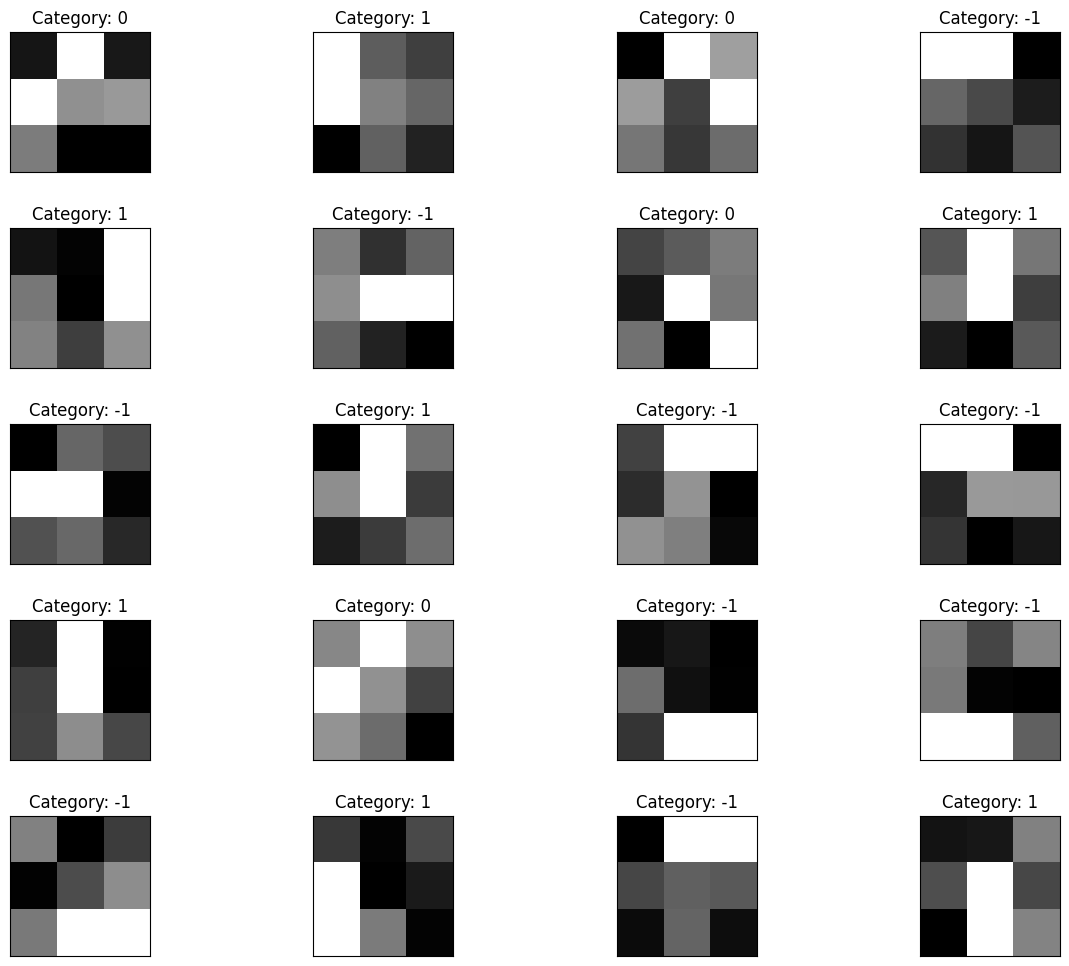

In [1]:
# This code defines the images to be classified:
import numpy as np 

# Total number of "pixels"/qubits
size = 9
# One dimension of the image (vertical; must divide `size`)
vert_size = 3
# Length of the lines to be drawn
line_size = 2
hor_size = size // vert_size

# Prepare the base arrays for each type of line:
# 1) Horizontal
hor_array = np.zeros((size - (line_size - 1) * vert_size, size))
j = 0
for i in range(size):
    if i % hor_size <= hor_size - line_size:
        for p in range(line_size):
            hor_array[j][i + p] = np.pi / 2
        j += 1

# 2) Vertical
ver_array = np.zeros((hor_size * (vert_size - line_size + 1), size))
j = 0
for i in range(hor_size * (vert_size - line_size + 1)):
    for p in range(line_size):
        ver_array[j][i + p * hor_size] = np.pi / 2
    j += 1

# 3) Diagonal “\” (downward to the right)
num_diag_down = (vert_size - line_size + 1) * (hor_size - line_size + 1)
diag_down_array = np.zeros((num_diag_down, size))
j = 0
for r in range(vert_size - line_size + 1):
    for c in range(hor_size - line_size + 1):
        for p in range(line_size):
            idx = (r + p) * hor_size + (c + p)
            diag_down_array[j][idx] = np.pi / 2
        j += 1

# 4) Diagonal “/” (upward to the right)
num_diag_up = (vert_size - line_size + 1) * (hor_size - line_size + 1)
diag_up_array = np.zeros((num_diag_up, size))
j = 0
for r in range(vert_size - line_size + 1):
    for c in range(line_size - 1, hor_size):
        for p in range(line_size):
            idx = (r + p) * hor_size + (c - p)
            diag_up_array[j][idx] = np.pi / 2
        j += 1

# Merge both diagonal directions into a single array
diag_array = np.vstack((diag_down_array, diag_up_array))


def generate_dataset(num_images):
    images = []
    labels = []
    # We define 3 classes: -1=horizontal, 1=vertical, 0=diagonal
    for _ in range(num_images):
        rng = np.random.randint(0, 3)
        if rng == 0:
            labels.append(-1)
            img_idx = np.random.randint(0, len(hor_array))
            img = np.array(hor_array[img_idx])
        elif rng == 1:
            labels.append(1)
            img_idx = np.random.randint(0, len(ver_array))
            img = np.array(ver_array[img_idx])
        else:  # rng == 2
            labels.append(0)
            img_idx = np.random.randint(0, len(diag_array))
            img = np.array(diag_array[img_idx])

        # Add some noise to the image pixels off the line
        for i in range(size):
            if img[i] == 0:
                img[i] = np.random.rand() 

        images.append(img)

    return images, labels


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)
image_sample_size = 600
images, labels = generate_dataset(image_sample_size)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

# Showing some images from the dataset
n_rows = 5  
n_cols = 4  
n_images = n_rows * n_cols  

titles = [f'Category: {train_labels[i]}' for i in range(n_images)]
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 12), subplot_kw={"xticks": [], "yticks": []})

for i in range(n_images):
    ax[i // n_cols, i % n_cols].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
        cmap='gray'
    )
    ax[i // n_cols, i % n_cols].set_title(titles[i])

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

## Mapping the qubits

In [2]:
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap

# One qubit per data feature
num_qubits = len(train_images[0])

# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = ZFeatureMap(num_qubits, parameter_prefix='a')

# Check the circuit depth, and the two-qubit gate depth
print(f"Full circuit depth: {feature_map.decompose(10).depth()}")
print(f"2-qubit gates circuit depth: {feature_map.decompose(10).depth(lambda instr: len(instr.qubits) > 1)}")

Full circuit depth: 1
2-qubit gates circuit depth: 1


## Ansatz Construction

Our quantum circuit design is optimized for image pattern recognition. We use two layers of rotation gates (RY and RX) with CNOT gates in between to create correlations between adjacent pixels. Since we're classifying horizontal, vertical, and diagonal lines, we connect each qubit with its neighbors in all directions (up, down, left, right). This structure allows the circuit to capture spatial relationships between pixels, which is crucial for detecting line patterns in images.

Full circuit depth: 10
2-qubit gates circuit depth: 9


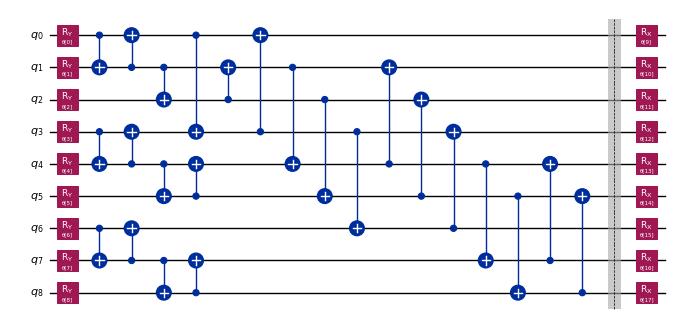

In [3]:
# Import the necessary packages
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)

# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2*size)

# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)

# Create horizontal and vertical connections in both directions
qnn_cnot_list = []

# Horizontal connections (qubit with previous and next)
for i in range(size):
    # Connection with the previous if not at the start of a row
    if i % vert_size != 0:
        qnn_cnot_list.append([i, i-1])
    # Connection with the next if not at the end of a row
    if (i + 1) % vert_size != 0:
        qnn_cnot_list.append([i, i+1])

# Vertical connections (qubit with the one vert_size positions before and after)
for i in range(size):
    # Connection with the qubit above
    if i >= vert_size:
        qnn_cnot_list.append([i, i-vert_size])
    # Connection with the qubit below
    if i < size - vert_size:
        qnn_cnot_list.append([i, i+vert_size])

# Apply the CNOT gates
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])

# Add a barrier after the CNOT gates
qnn_circuit.barrier()

# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size+i], i)

# Check the circuit depth, and the two-qubit gate depth
print(f"Full circuit depth: {qnn_circuit.decompose(10).depth()}")
print(f"2-qubit gates circuit depth: {qnn_circuit.decompose(10).depth(lambda instr: len(instr.qubits) > 1)}")

# Draw the circuit
qnn_circuit.draw('mpl', scale=0.5)

## Merging both ansatz and feature map

Full circuit depth: 11
2-qubit gates circuit depth: 10


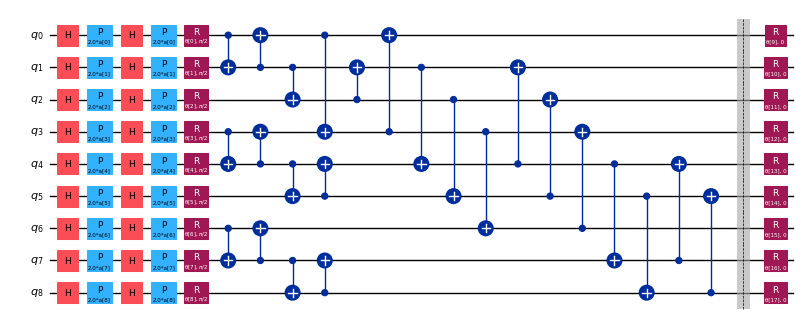

In [4]:
# QNN ansatz
ansatz = qnn_circuit

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Check the circuit depth, and the two-qubit gate depth
print(f"Full circuit depth: {full_circuit.decompose(10).depth()}")
print(f"2-qubit gates circuit depth: {full_circuit.decompose(10).depth(lambda instr: len(instr.qubits) > 1)}")

# Display the circuit
full_circuit.decompose().draw("mpl", scale=0.5)

## Defining an observable

We define a measurement observable that applies Pauli Z gates to all qubits. This allows us to measure the collective quantum state and classify the image patterns based on the expectation values.

In [5]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

## Some important functions

The forward pass function is a crucial part of our quantum neural network. It:

1. Takes input data (image pixels) and trainable parameters (weights)
2. Runs them through our quantum circuit
3. Measures the expectation value of our Z-observable on all qubits
4. Returns these measurements as predictions (-1 for horizontal, 0 for diagonal, +1 for vertical lines)

This is analogous to how classical neural networks propagate data through their layers, but using quantum operations instead of matrix multiplications.

In [6]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator


def forward(circuit: QuantumCircuit,
            input_params: np.ndarray, 
            weight_params: np.ndarray, 
            estimator: BaseEstimatorV2,
            observable: BaseOperator
) -> np.ndarray:
    """
    Forward pass of the neural network.
    
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive. 
        observable: a single oberservable to compute the expectation over.

    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs

    return expectation_values

Next, we need a loss function to calculate the difference between the predicted and calculated values of the labels. The function will take in the labels predicted by the algorithm and the correct labels and return the mean squared difference. There any many different loss functions. Here, MSE is an example that we chose.

In [7]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError ("input should be 1d-array")

Let us also define a slightly different loss function that is a function of the variable parameters (weights), for use by the classical optimizer. This function only takes the ansatz parameters as input; other variables for the forward pass and the loss are set as global parameters. The optimizer will train the model by sampling different weights and attempting to lower the output of the cost/loss function.

In [8]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    predictions = forward(circuit=circuit, 
                          input_params=input_params, 
                          weight_params=weight_params, 
                          estimator=estimator, 
                          observable=observable)
    
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
    
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

## Optimize problem for quantum execution 

We start by selecting a backend for execution. In this case, we will use the least-busy backend.

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

ibm_brisbane


Here we optimize the circuit for running on a real backend by specifying the optimization_level and adding dynamical decoupling. The code below generates a pass manager using preset pass managers from qiskit.transpiler.

In [10]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
        PadDynamicalDecoupling(
            target=target, dd_sequence=[XGate(), XGate()], pulse_alignment=target.pulse_alignment
        ),
    ]
)

Now we use the pass manager on the circuit. The layout changes that result must be applied to the observable as well. For very large circuits, the heuristics used in circuit optimization may not always yield the best and shallowest circuit. In those cases it makes sense to run such pass managers several times and use the best circuit. 

In [11]:
circuit_ibm = pm.run(full_circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

## Training Process

In this section, we perform the model training using mini-batch gradient descent:

1. We use a quantum simulator (StatevectorEstimator) for faster development
2. Split our training data into smaller batches for efficient processing
3. Initialize random weights for our quantum circuit parameters
4. Run optimization for each batch over one epoch, using COBYLA algorithm to minimize our loss function
5. The optimizer tries different weight values to find parameters that best classify our line patterns

This balances computational efficiency with learning effectiveness.

In [12]:
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize

batch_size = image_sample_size // 4    
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(mse_loss_weights, weight_params, method='COBYLA', options={'maxiter': 100})
        weight_params = res['x']

Epoch: 0, batch: 0
Iter: 0, loss: 0.7157542541142672
Iter: 50, loss: 0.6429550922546069
Epoch: 0, batch: 1
Iter: 0, loss: 0.5019287946618177
Iter: 50, loss: 0.41546498253237557
Epoch: 0, batch: 2
Iter: 0, loss: 0.36595220834787107
Iter: 50, loss: 0.35983452233630475


## Post-process

Here we evaluate our trained model's performance:

1. We use the optimized circuit parameters to make predictions on our training data
2. Convert the quantum measurements into class labels:
   - Values near 0 (±0.1) are classified as diagonal lines (0)
   - Values below -0.1 are classified as horizontal lines (-1) 
   - Values above 0.1 are classified as vertical lines (+1)
3. Compare our predictions with the true labels using accuracy score
4. This tells us how well our quantum classifier learned to distinguish between the different line patterns

This process lets us quantify our model's classification performance on both training and test data.

In [13]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(train_images), res['x'], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

threshold = 0.1
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[(pred_train_labels > -threshold) & (pred_train_labels < threshold)] = 0 # diagonal
pred_train_labels[pred_train_labels < -threshold ] = -1 # horizontal
pred_train_labels[pred_train_labels > threshold] = 1 # vertical
print(pred_train_labels)
print(train_labels)



accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.15881555  0.18335964  0.18701299 -0.13325368  0.44463038 -0.42348602
 -0.04560928  0.53021423 -0.10720043  0.38068702 -0.36369138 -0.20304613
  0.60940355  0.16204704 -0.39776226 -0.4600459  -0.24265841 -0.00325351
 -0.36170779  0.1860829   0.10833917  0.0941986   0.67664888 -0.00240475
 -0.28922555 -0.4735332   0.19219994  0.1593067   0.20804585  0.01793719
 -0.04703452  0.09103807 -0.10692701 -0.14202673 -0.18087971  0.20332884
 -0.34853796  0.19809518 -0.45971168  0.19073785  0.39825734  0.42409688
  0.43230212  0.43284599  0.10075183  0.080855    0.26953915 -0.01006739
 -0.40158006 -0.44683045 -0.33431316  0.10690134  0.2641474   0.58467282
 -0.6648009  -0.35216868  0.18108992  0.64397027  0.27131016  0.26237026
  0.42626759 -0.27123269 -0.05565248  0.14544057 -0.47822905 -0.15918367
 -0.31108844  0.09100503 -0.213593   -0.22856438  0.07079544 -0.20882722
 -0.16754673 -0.58108206 -0.39414761  0.19358563 -0.18520467 -0.60712603
  0.20183372 -0.28236979  0.52180919  0.3597048  -0

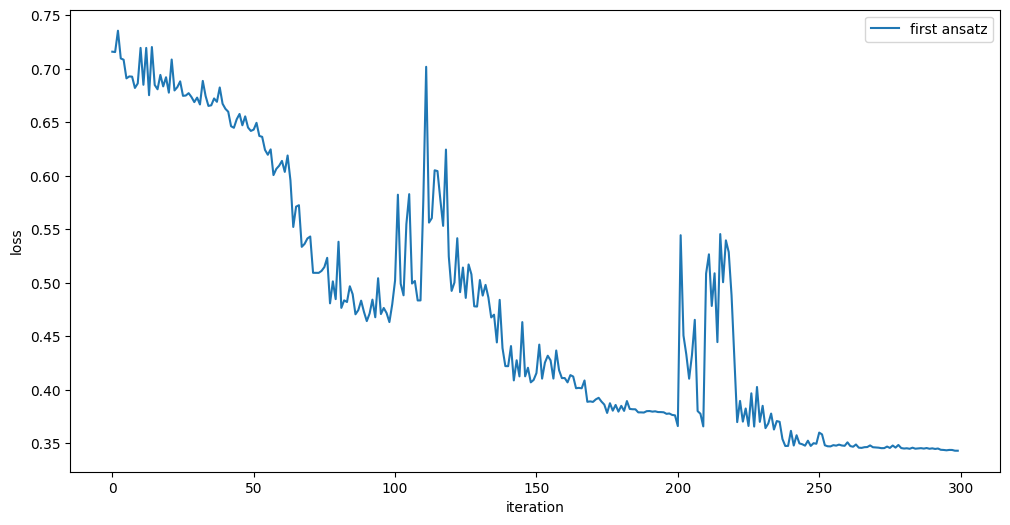

In [14]:
obj_func_vals_first = objective_func_vals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first,label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [15]:
pred_test = forward(circuit, np.array(test_images), res['x'], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[-0.23601763  0.26201816 -0.24459351  0.55417426 -0.24680324  0.15631791
  0.31644834  0.49755519  0.26113158 -0.33220186  0.28192827 -0.09873939
 -0.27999807  0.62306614  0.32750756  0.34592536  0.05452488  0.00755905
 -0.34006416  0.13091815 -0.15007916 -0.18503215 -0.17602016  0.65036511
 -0.43879535 -0.15417051 -0.28618557  0.24507093 -0.08123406 -0.11505107
  0.31289051  0.05042816 -0.23461193 -0.31421298 -0.21312914 -0.22091605
  0.44187285 -0.23378501 -0.07089195  0.01654049  0.01353731  0.59684801
  0.20734101 -0.3528228  -0.1139483   0.50321009  0.53804382 -0.11399179
  0.08585631 -0.3390137   0.25316916  0.07681283  0.4710412  -0.22874498
 -0.47006299 -0.0296365  -0.42431538  0.62273272  0.17053464  0.217823
  0.14811067  0.21131468  0.01218784  0.35071779 -0.38701209 -0.38783316
 -0.57670259 -0.03971976 -0.48418688  0.11907462  0.04368376  0.07337639
  0.07847426 -0.40977928  0.22080621  0.53419072 -0.3107122   0.39994105
 -0.18044586 -0.39762116 -0.0293096   0.14011967  0.1

Here we can annalyze which images where misslabeled. 

3


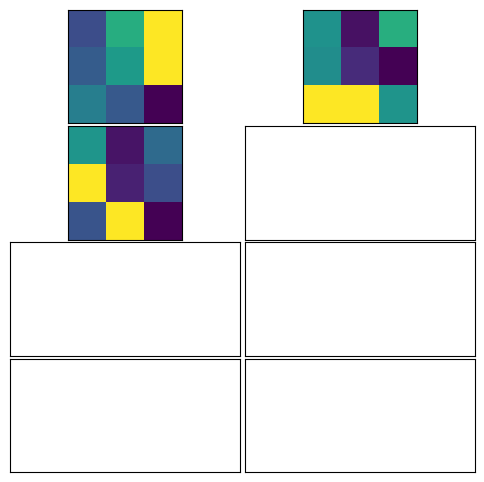

In [25]:
missed=[]
for i in range(len(test_labels)):
    if pred_test_labels[i]!=test_labels[i]:
        missed.append(test_images[i])
print(len(missed))
fig, ax = plt.subplots(4,2, figsize=(6, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(len(missed)):
    ax[i // 2, i % 2].imshow(
        missed[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.02, hspace=0.025)

## Scaling and running in real computers

Because computation time in quantum computers is a precious thing, let's use a smaller sample of images for this case

In [16]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
# Here we specify a very small data set. Increase for realism, but monitor use of quantum computing time.
images, labels = generate_dataset(10)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

Now let´s repeat the previous process encoding the data into qubits and constructing the ansatz 

In [17]:
# One qubit per data feature
num_qubits = len(train_images[0])

# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = ZFeatureMap(num_qubits, parameter_prefix='a')

#Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)

#We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2*size)

#A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i],i)

# Creamos conexiones horizontales y verticales en ambas direcciones
qnn_cnot_list = []

# Conexiones horizontales (qubit con anterior y siguiente)
for i in range(size):
    # Conexión con el anterior si no estamos al inicio de una fila
    if i % vert_size != 0:
        qnn_cnot_list.append([i, i-1])
    # Conexión con el siguiente si no estamos al final de una fila
    if (i + 1) % vert_size != 0:
        qnn_cnot_list.append([i, i+1])

# Conexiones verticales (qubit con el que está vert_size posiciones antes y después)
for i in range(size):
    # Conexión con el qubit de arriba
    if i >= vert_size:
        qnn_cnot_list.append([i, i-vert_size])
    # Conexión con el qubit de abajo
    if i < size - vert_size:
        qnn_cnot_list.append([i, i+vert_size])

# Aplicar las puertas CNOT
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
#The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size+i],i)

#Combine the feature map and variational circuit
ansatz = qnn_circuit

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Check the depth of the full circuit
print(f"Full circuit depth: {full_circuit.decompose(10).depth()}")
print(f"2-qubit gates circuit depth: {full_circuit.decompose(10).depth(lambda instr: len(instr.qubits) > 1)}")


Full circuit depth: 11
2-qubit gates circuit depth: 9


In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_circuit_layout, plot_error_map, plot_gate_map

service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
# backend = service.least_busy(operational=True, simulator=False)
backend = service.backend("ibm_sherbrooke")
print(f"backend: {backend.name}")


backend: ibm_sherbrooke


In [19]:
# plot_gate_map(backend)
# plot_circuit_layout(backend)
# plot_error_map(backend)

Next block optimizes the quantum circuit for hardware execution. It configures a PassManager with optimization level 3, including ALAP scheduling and constrained rescheduling. The circuit is transpiled multiple times to find the shallowest version by comparing depths, especially for two-qubit gates. This ensures efficient execution on quantum hardware by minimizing resource usage while maintaining circuit functionality.

In [20]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
        
    ]
)

# Try pass manager several times, since heuristics can return various transpilations on large circuits, and we want the shallowest.

transpiled_qcs=[]
transpiled_depths=[]
transpiled_2q_depths=[]
for i in range(1,10):
    circuit_ibm = pm.run(full_circuit)
    transpiled_qcs.append(circuit_ibm)
    transpiled_depths.append(circuit_ibm.decompose().depth())
    transpiled_2q_depths.append(circuit_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1))
    # print(i)


print(f"Transpiled depths: {transpiled_depths}")
print(f"Transpiled 2-qubit depths: {transpiled_2q_depths}")
# Use the shallowest 

minpos = transpiled_2q_depths.index(min(transpiled_2q_depths))

Transpiled depths: [192, 165, 211, 191, 195, 165, 165, 171, 186]
Transpiled 2-qubit depths: [44, 38, 52, 44, 44, 38, 40, 38, 44]


In [21]:
circuit_ibm = transpiled_qcs[minpos]
observable_ibm = observable.apply_layout(circuit_ibm.layout)
print(f"Chosen circuit depth: {circuit_ibm.decompose().depth()}")
print(f"Chosen circuit 2-qubit gates depth: {circuit_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)}")
# circuit_ibm.draw('mpl', scale=0.5, fold=40)

Chosen circuit depth: 165
Chosen circuit 2-qubit gates depth: 38


In [ ]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Session, Options as EstimatorOptions

batch_size = 7
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = circuit_ibm
observable = observable_ibm
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

# Create a session with the backend and use that session for the estimator
with Session(backend=backend) as session:
    # Initialize the estimator with the existing session
    estimator = Estimator(options={"resilience_level": 1})
    
    for epoch in range(num_epochs):
        for i in range((num_samples - 1) // batch_size + 1):
            print(f"Epoch: {epoch}, batch: {i}")
            start_i = i * batch_size
            end_i = start_i + batch_size
            train_images_batch = np.array(train_images[start_i:end_i])
            train_labels_batch = np.array(train_labels[start_i:end_i])
            input_params = train_images_batch
            target = train_labels_batch
            iter = 0
            # We can increase maxiter to do a full optimization.
            res = minimize(mse_loss_weights, weight_params, method='COBYLA', options={'maxiter': 20})
            weight_params = res['x']

Epoch: 0, batch: 0
